In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()
from pandas.api.types import is_numeric_dtype
from typing import Optional
from helper_functions import *

In [2]:
cust_data = pd.read_csv("customer_segmentation_data.csv")

In [3]:
cust_data.head()

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


In [4]:
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minutes_watched  3725 non-null   float64
 1   CLV              3834 non-null   float64
 2   region           3834 non-null   int64  
 3   channel          3834 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 119.9 KB


## Feature explanation

- **minutes watched** *(int)* — Total minutes a student has watched since joining the program.  
- **CLV** *(float)* — Customer Lifetime Value: total revenue generated by that student.  
- **Region** *(categorical; codes {0,1,2})* — Student’s geographic region:  
  - `0` = USA, Canada, United Kingdom, Australia  
  - `1` = Western Europe  
  - `2` = Rest of the World  
- **Channel** *(categorical; codes {1–8})* — How the customer learned about the 365 program:  
  - `1` = Google, `2` = Facebook, `3` = YouTube, `4` = LinkedIn,  
  - `5` = Twitter, `6` = Instagram, `7` = Friend, `8` = Other

**Note:** `minutes watched` and `CLV` are numeric; `Region` and `Channel` are categorical.


## Null values

In [5]:
cust_data.isnull().sum()

minutes_watched    109
CLV                  0
region               0
channel              0
dtype: int64

## Descriptive statistics

In [6]:
cust_data.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


`minutes_watched` has 2.84% missing values, a heavy right tail (mean 1,972 vs median 512), and the extreme maxima (~200 days) seems unreasonably high. 

## Data Transformations

I'll map numeric values that represent categories so they're easier to interpret.

In [7]:
region_map  = {0: "US/CA/UK/AU", 1: "Western Europe", 2: "Rest of World"}
channel_map = {
    1: "Google", 2: "Facebook", 3: "YouTube", 4: "LinkedIn",
    5: "Twitter", 6: "Instagram", 7: "Friend", 8: "Other"
}

# Adjust column names if yours differ
cust_data["region"]  = cust_data["region"].map(region_map).astype("category")
cust_data["channel"] = cust_data["channel"].map(channel_map).astype("category")

## EDA

### Univariate Analysis 

Let's visualize the data and spot hidden patterns through graphical analysis.

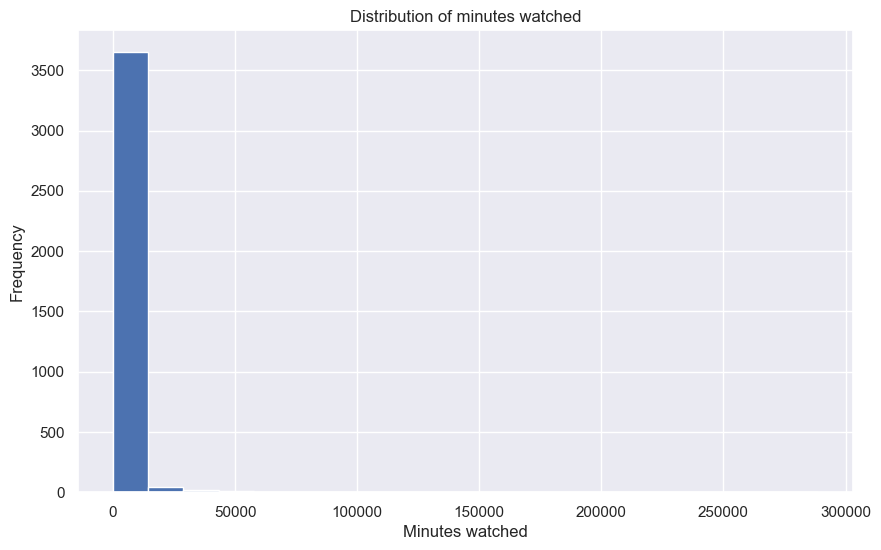

In [8]:
plot_numeric_data(
    df=cust_data, 
    col_to_plot="minutes_watched", 
    chart_title="Distribution of minutes watched",
    x_label="Minutes watched",
    y_label="Frequency",
    bins=20)

The distribution shows an extremely right-skewed shape, with a huge mass near 0-2k minutes (perc 75 is 1500 minutes) and a very long tail (max ≈ 288,508 min ≈ 200 days). This implies that a few "power-users" (or data errors) drive the tail, this makes the median (512) much lower than the mean (1972), confirming a heavy skew. 

We can trim to the 99th percentile to see the distribution better:

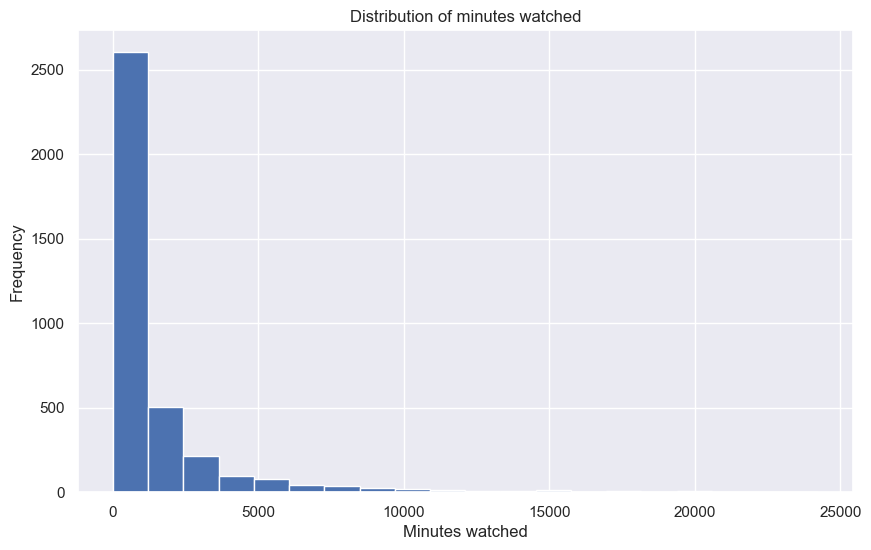

In [9]:
mw_perc_99 = cust_data["minutes_watched"].quantile(.99)
cust_data_trimmed = cust_data.loc[cust_data["minutes_watched"] < mw_perc_99]

plot_numeric_data( 
    df=cust_data_trimmed, 
    col_to_plot="minutes_watched", 
    chart_title="Distribution of minutes watched",
    x_label="Minutes watched",
    y_label="Frequency",
    bins=20)

Excluding the last 1% of the data in this column we still get a right skewed distribution but the maximum value is more reasonable that the one we had before.

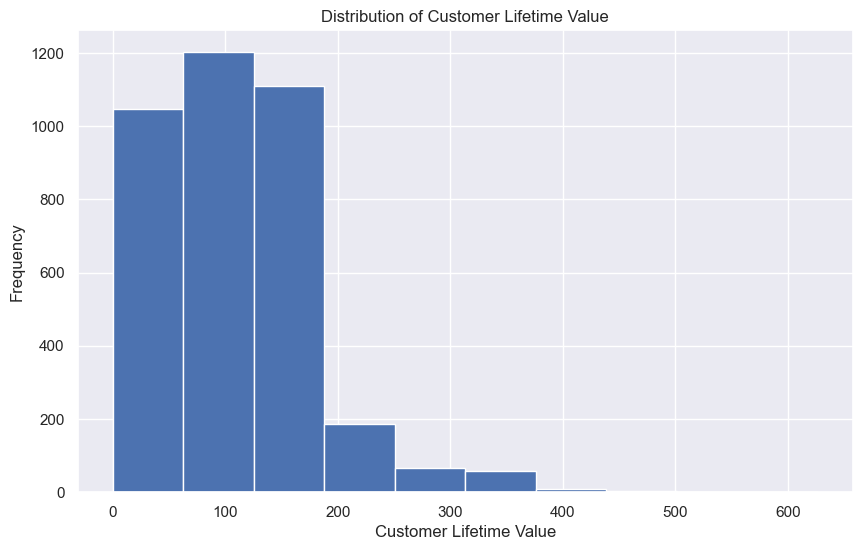

In [10]:
plot_numeric_data(
    df=cust_data_trimmed,
    chart_title="Distribution of Customer Lifetime Value",
    col_to_plot="CLV",
    x_label="Customer Lifetime Value",
    y_label="Frequency"
)

In this case, the skew is moderate, with a mean of 118 and a median of 119, so the outliers aren't that extreme compared with the minutes distribution. A few high-value customers exist.

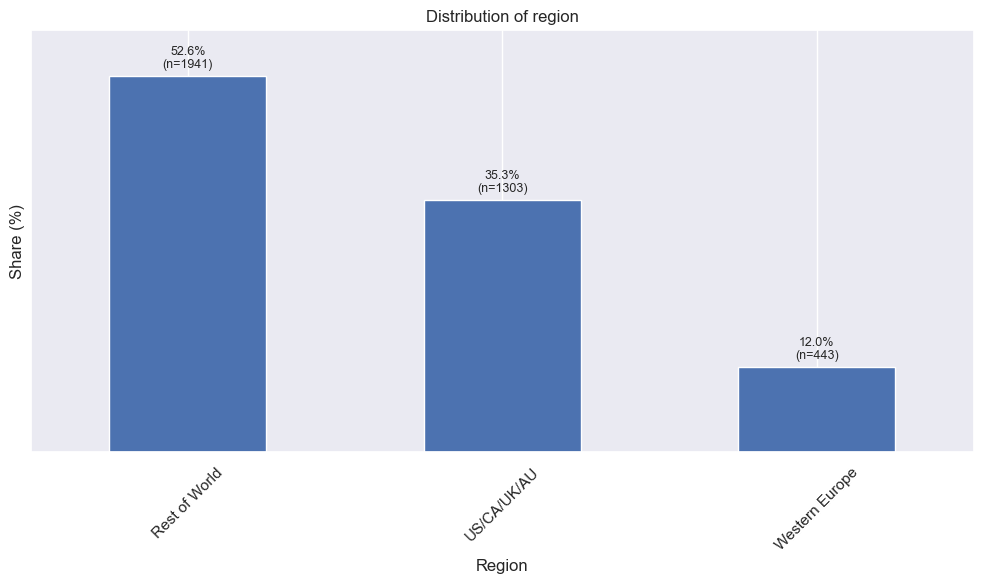

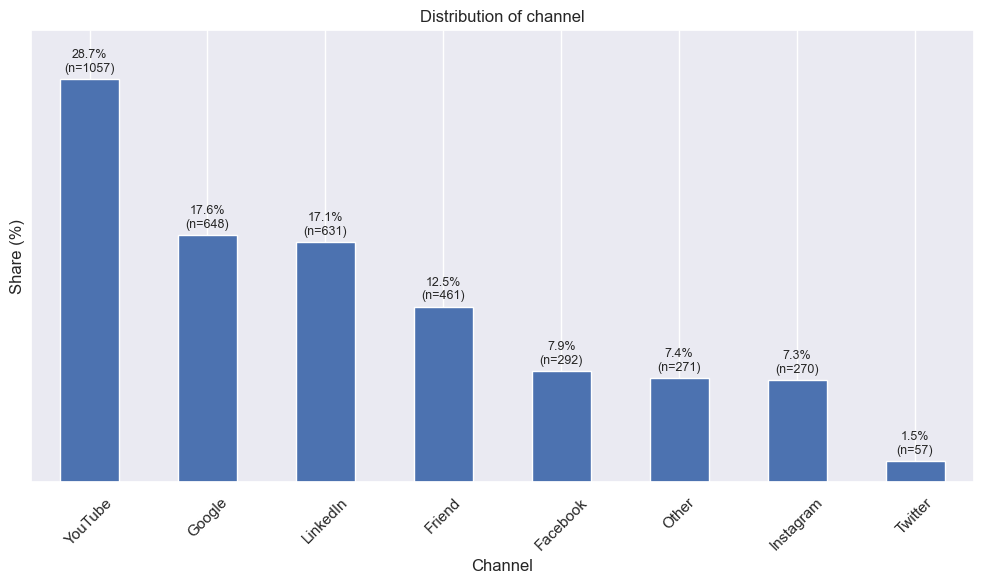

In [11]:
for col, title, x_label in [("region", "Distribution of region", "Region"), ("channel", "Distribution of channel", "Channel")]:
    plot_categorical_data(
        df=cust_data_trimmed,
        col_to_plot=col,
        chart_title=title,
        x_label=x_label
    )

#### Main insights from the charts

**Minutes watched (numeric)**
- Histogram **trimmed to the 99th percentile** to handle a suspicious outlier (~**200 days** of watch time), likely a data-quality issue.
- Distribution is **heavily right-skewed** with a long tail; most users watch relatively low amounts compared to a few heavy users.
- Median (≈ **512 min**) is far below the mean (≈ **1,972 min**), confirming skew.

**Customer Lifetime Value (CLV)**
- **Moderately right-skewed**: most customers fall roughly in the **50–200** range, with a thin tail up to **~600**.
- Mean (≈ **118**) and median (≈ **119**) are close, indicating far fewer extreme outliers than in minutes watched.

**Region**
- Most students come from **Rest of World (~52.6%)**.
- **US/CA/UK/AU (~35.3%)** is the next largest group.
- **Western Europe (~12.0%)** is comparatively small → the sample is region-imbalanced.

**Acquisition Channel**
- **YouTube (~28.7%)** is the dominant source.
- **Google (~17.6%)** and **LinkedIn (~17.1%)** are the next strongest channels.
- **Referrals (“Friend”, ~12.5%)** are meaningful.
- **Facebook/Instagram/Other** each contribute **~7–8%**.
- **Twitter (~1.5%)** is negligible in this sample.

**Additional Notes: (EDA-stage, to validate)** 

- **Markets:** Western Europe + US/CA/UK/AU account for **~47%** of students in this sample. If this mix reflects the addressable market, focusing campaigns here could simplify execution.  
  *Next step:* verify representativeness and compare **CLV/engagement (minutes_watched)** and **retention** by region before prioritizing spend.

- **Channels:** **YouTube, Google, and LinkedIn (~63% combined share)** supply most acquisitions. They are strong sources, but **share ≠ effectiveness**.  
  *Next step:* evaluate **unit economics** per channel — CLV, median minutes watched, conversion rate (if available), and **CAC/ROI** — before shifting budget. Keep an eye on **referrals (“Friend”, 12.5%)** as a potentially high-ROI lever.

*These are exploratory insights; confirm with per-segment performance and cost data before making allocation decisions.*

### Multivariate Analysis
Now let's study the interaction between variables